## Assignment 3 Question 2

Is it possible to predict ELO of a player based on context of a potential en passant move?

Only investigating the player who is in the position of making the en passant move.

Lila See FDS PCA solutions for 3 good points for what PCA is good for - include in report?

#### Import Libraries

In [1]:
import pandas as pd
import chess
import chess.pgn
import chess.engine
import io
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import importlib
import math

from pandarallel import pandarallel

import data_cleaning

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Import stockfish 🐟🐟🐟

In [2]:
# Windows installation
STOCKFISH_LOC = os.getcwd() + "\stockfish\stockfish-windows-2022-x86-64-avx2.exe"
# Unix based installation i.e. DICE/Codespaces
STOCKFISH_LOC_UNIX = os.getcwd() + "/stockfish_14_linux/stockfish_14_x64"

# Import stockfish package
from stockfish import Stockfish
# Try and read windows location
try:
    fish = Stockfish(path=STOCKFISH_LOC, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# If error, read the linux location
except:
    fish = Stockfish(path=STOCKFISH_LOC_UNIX, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# It will throw an error but if it still runs then ignore it :D

#### Import CSV file

66879 entries in dataframe

In [3]:
chess_data = data_cleaning.import_data()
print(chess_data.dtypes)

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object


#### Dataframe info

Using:
print(chess_data.dtypes)
print(chess["rules"].unique())


Chess rules:
['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']

Time control:
['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
 '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
 '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
 '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
 '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
 '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
 '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
 '60+10']

 Time class:
['daily' 'rapid' 'bullet' 'blitz']

#### Clean data

Undeveloped board shouldn't matter if we're filtering games for potential ep

Same for draws

Can filter our time class if are looking at time controls

After making a new move_list column, should we drop the pgn column?


Variables we are considering when predicting ELO (for a player who could potentially make en passant move) are:
- Colour who had ep opportunity (boolean)
- Did they take the en passant? (boolean)
- Does their choice on taking/not taking support them if gaining an advantage? (numerical value for how much of an advantage it gives) [Lila rn is __________________]
- 
- Time taken to decide to capture/not capture en passant (percentage of total time for the game)
- Is the game rated? (boolean)
- Game time class (numerical value), don't include daily because daily don't have times attached to move

In [4]:
# Save PGN column from dataframe
full_pgn = chess_data['pgn']

def get_moves(entry):
    '''
    Retrive series of moves in a game when given the whole full_pgn entry.
    '''
    pgn = entry.splitlines()[-1]
    return pgn

# Add list of moves (string) as a new column to dataframe
chess_data['move_list'] = full_pgn.apply(get_moves)

# Drop irrelevant columns
chess_data = chess_data.drop(['white_username', 'black_username','white_id', 'black_id', 'white_result', 'black_result', 'rules'], axis=1)

### Processing data and adding information

#### Checks every game for ones that have potential en-passant moves
- Gets whether a game has an en-passant opportunity
- Gets whether the said en passant move was played
- Gets the colour of the player that has the e.p. opportunity

In [5]:
def check_pgn(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False
    moved = False
    move_colour = ""

    # comparison sets when checking move piece
    ep_set = set(["ax","bx","cx","dx","ex","fx","gx", "hx"])
    check_set = set("abcdefgh")
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        move = board_move.move
        san = board.san(move)
        turn = board.turn
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # print(board_move.clock())
            # get first 2 letters, and compare to a set
            move_ep_piece = san[:2]
            if move_ep_piece in ep_set:
                # check if e.p. actually happened
                moved = board.is_en_passant(move)
            # break out for loop, no need to check further
            break
        
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # if precheck is true then set the turn
            if precheck:
                if turn:
                    move_colour = 'Black'
                else:
                    move_colour = 'White'
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    
    # set row values
    df_row["ep_opportunity"] = precheck
    df_row["ep_happened"] = moved
    df_row["ep_colour"] = move_colour
    return df_row

chess_filter = chess_data.copy(deep=True)
# chess_filter = chess_data[chess_data["time_class"] != "daily"].sample(100).copy(deep=True)
pandarallel.initialize()

start = time.time()
# apply e.p. finding function
try:
    chess_filter = chess_filter.parallel_apply(check_pgn, axis=1)
except:
    chess_filter = chess_filter.apply(check_pgn, axis=1)
end = time.time()
print(end - start)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
59.459200859069824


#### Filter out games that don't have en-passant opportunity

In [6]:
chess_filter = chess_filter[chess_filter['ep_opportunity'] == True]
chess_filter = chess_filter.drop(['ep_opportunity'], axis=1)
chess_filter = chess_filter.reset_index(drop=True)
print(len(chess_filter))
print(len(chess_filter[chess_filter['ep_happened'] == True]))
# print(chess_filter["move_list"].sample(50).head(20))

5074
1563


#### Get the time taken to respond to an en-passant pawn move

In [7]:

def check_times(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    # print(df_row["move_list"])
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False

    # comparison sets when checking move piece
    check_set = set("abcdefgh")
    
    rolling_white_time = [0,0]
    rolling_black_time = [0,0]
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        # print(board_move.clock())
        if board.turn:
            rolling_white_time = [board_move.clock(), rolling_white_time[0]]
            # print(rolling_white_time)
        else:
            rolling_black_time = [board_move.clock(), rolling_black_time[0]]
            # print(rolling_black_time)
        
        move = board_move.move
        san = board.san(move)
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # print(board_move.clock())
            # get first 2 letters, and compare to a set
            norm = df_row["time_control"]

            if board.turn:
                df_row["time_taken"] = (rolling_white_time[1] - rolling_white_time[0])/float(norm)
            else:
                df_row["time_taken"] = (rolling_black_time[1] - rolling_black_time[0])/float(norm)
            # print(df_row)
            return df_row
        
        # if the move was a pawn (lower case)
        # print(move_piece)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # print(precheck)
            # if precheck is true then set the turn
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    return df_row

pandarallel.initialize()

start = time.time()
# apply e.p. finding function
try:
    chess_filter = chess_filter.parallel_apply(check_times, axis=1)
except:
    chess_filter = chess_filter.apply(check_times, axis=1)
end = time.time()
print(end - start)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
5.422538757324219


#### Stockfish Evaluation to get evaluations of board choices
- Gets the evaluation before an ep opportunity
- Gets the evaluation of the best move calculated by Stockfish
- Gets the evaluation of the (best) en passant move calculated by Stockfish

In [8]:
import stockfish_eval
importlib.reload(stockfish_eval);

def stockfish_analyse_board(df_row, board, move):
    '''
    Gets a stockfish evaluation of the best move played,
    and also the evaluation if e.p. is played.
    Returns a triple of pre-move evaluation, evaluation difference of best
    move, evaluation difference of (best) en passant move.
    '''
    fish_eval = stockfish_eval.StockfishEval(fish, board, df_row["ep_colour"])

    # reset fen
    fish_eval.reset_fen()
    
    fish_eval.set_player_move(move)
    # get pre-move evaluation
    pre_eval = fish_eval.evaluate_board()["value"]
    
    # if player_move_is_ep:
    fish_eval.get_best_move()
    # else:
    fish_eval.find_adj_squares()
    fish_eval.find_bounds()
    fish_eval.find_valid_pawns()
    fish_eval.find_ep_moves()
        
        
    # should end up with either
    
    # self.move_list = {
    #             "best_move": "move",
    #             "player_move": "",
    #             "ep_move_left": "maybe a move",
    #             "ep_move_right": "maybe a move"
    #         }
    
    # or
    
    # self.move_list = {
    #             "best_move": "",
    #             "player_move": "move",
    #             "ep_move_left": "maybe a move",
    #             "ep_move_right": "maybe a move"
    #         }
    
    # if the user played EP, then get eval of the users board
    # and get the eval of what the best move would have been
    moveList = fish_eval.get_movelist()
    
    best_eval = fish_eval.evaluate_best_move()
    best_difference = fish_eval.get_abs_advantage(best_eval, pre_eval)
    
    if moveList["best_move"] == moveList["ep_move_left"] or moveList["best_move"] == moveList["ep_move_right"]:
        ep_eval = best_eval
        ep_difference = best_difference
    else:
        ep_eval = fish_eval.evaluate_en_passants()
        ep_difference = fish_eval.get_abs_advantage(ep_eval, pre_eval)
    
    
    if fish_eval.get_movelist()["best_move"] == move:
        best_eval = best_eval
        player_difference = best_difference
    else:
        player_eval = fish_eval.evaluate_player_move()
        player_difference = fish_eval.get_abs_advantage(player_eval, pre_eval)
        
    return [pre_eval, best_difference, ep_difference, player_difference]

def get_advantage(df_row):
    '''
    Get stockfish evaluations for a given game
    Sets columns "pre_state", "state_best", "state_ep" for a df row
    '''
    # pawn lookup set
    check_set = set("abcdefgh")
    # print(df_row.name)
    
    # initialise board
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game

    # e.p. check
    precheck = False
    
    # initialise vars
    pre_eval = 0
    best_eval = 0
    ep_eval = 0
    player_eval = 0
    
    # iterate over every move in a game
    for move in game.mainline_moves():
        # representation of a move
        san = board.san(move)
        move_piece = san[0]

        # check if precheck was flagged in previous move
        if precheck:
            # reset to not flag final move precheck edge case 
            precheck = False

            # analyse board
            values = stockfish_analyse_board(df_row, board, str(move))
            # print(values)
            # set values
            pre_eval = values[0]
            best_eval = values[1]
            ep_eval = values[2]
            player_eval = values[3]
            # break out of for loop since we have all values
            break
            
            
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)

    # edge case where the final move was pawn 2 space, and there is no next
    # move to run stockfish_analyse_board
    if precheck:
        # checkstr = df_row["pgn"]
        # if re.search("won\sby\s(time|resignation|abandoned)\"\]", checkstr) != None:
        #     df_row["pre_state"] = pd.NA     # pre-moved stockfish eval
        #     df_row["state_best"] = pd.NA  # stockfish eval if best move
        #     return df_row
        # # colour is the colour of the player with the opportunity
        # values = stockfish_analyse_board(df_row, board, san)
        # # set values
        pre_eval = pd.NA
        best_eval = pd.NA
        ep_eval = pd.NA
        player_eval = pd.NA
    
    # set dataframe values
    df_row["pre_state"] = pre_eval     # pre-moved stockfish eval
    df_row["state_best"] = best_eval  # stockfish eval if best move
    df_row["state_ep"] = ep_eval
    df_row["state_player"] = player_eval
    # print(df_row["pgn"])
    return df_row

print(len(chess_filter))
# get_advantage(chess_filter.iloc[486])
chess_filter = chess_filter.apply(get_advantage, axis=1)

5074


In [25]:
def get_player_rating(df_row):
    col = df_row["ep_colour"]
    if col == "White":
        elo = df_row["white_rating"]
    else:
        elo = df_row["black_rating"]
    df_row = df_row.drop(["white_rating", "black_rating"])
    df_row["player_rating"] = elo
    return df_row

# print(len(chess_filter[chess_filter["ep_happened"]]))

chess_filter = chess_filter.apply(get_player_rating, axis=1)

print(chess_filter.head(10))

1563


KeyError: 'white_rating'

### Applying PCA


standard deviation: 399.373996237217
mean: 1240.5744974379188


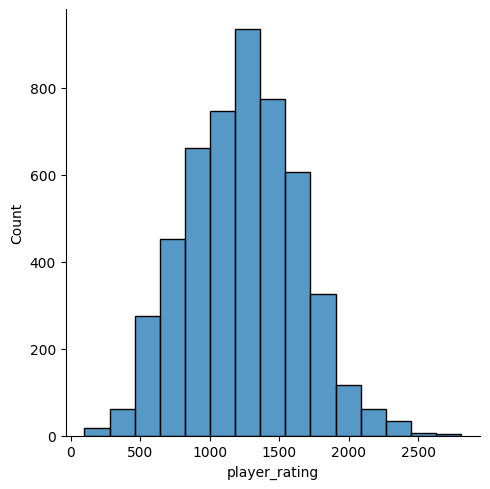

In [10]:
# chess_normal = chess_normal.groupby("elo_class").size().rename("total")
# print(chess_normal)

mean = chess_filter["player_rating"].mean()
std = chess_filter["player_rating"].std()

fhgt_hist = sns.displot(chess_filter["player_rating"], kde = False, bins = 15)

print("standard deviation: " + str(std))
print("mean: " + str(mean))

In [193]:
def group_elo_tens(df_row):
    df_row["elo_class_tens"] = int(math.ceil(df_row["player_rating"] / 10.0)) * 10
    return df_row

def divider(df_row):
    df_row["quotient"] = df_row["instances"] / df_row["total"]
    return df_row

def apply_quotient(df_row):
    num = df_row["elo_class_tens"]
    quot = temptation_quotient.loc[num]["quotient"]
    df_row["quotient"] = quot
    return df_row

def temptation(df_row):
    if (df_row["state_best"] == 0):
        df_row["temptation"] = pd.NA
    else:
        df_row["temptation"] = -1*(np.exp((df_row["state_best"] - df_row["state_ep"])/200)+1)
    return df_row

def group_elo_stds(df_row):
    elo = df_row["player_rating"]
    if elo <= (mean - std):
        df_row["elo_class"] = 1
    # elif elo <= mean:
    #     df_row["elo_class"] = 2
    elif elo <= (mean + std):
        df_row["elo_class"] = 2
    else:
        df_row["elo_class"] = 3
    # elif elo <= 2500:
    #     df_row["elo_class2"] = 5
    # else:
    #     df_row["elo_class2"] = 6
    return df_row

temptation_data = chess_filter.copy(deep=True)
# Group data by 10s

temptation_data = temptation_data.apply(group_elo_tens, axis=1)

# amount of times a group made an e.p. move
temptation_instances = temptation_data.groupby('elo_class_tens')['ep_happened'].sum().rename("instances")
# total amount of opportunities in a group
temptation_totals = temptation_data.groupby('elo_class_tens').size().rename("total")

temptation_quotient = pd.concat([temptation_instances, temptation_totals], axis=1)
temptation_quotient = temptation_quotient.apply(divider, axis=1)

temptation_data = temptation_data.dropna()
temptation_data = temptation_data.apply(apply_quotient, axis=1)
temptation_data = temptation_data.apply(temptation, axis=1)
temptation_data = temptation_data.dropna()

temptation_data = temptation_data.apply(group_elo_stds, axis=1)

elo_class = temptation_data["elo_class"]

temptation_data = temptation_data[temptation_data["time_taken"] > 0]

# temptation_data = temptation_data[temptation_data["state_ep"] < 0]
temptation_data = temptation_data[temptation_data["temptation"] > -1000]
temptation_data = temptation_data[temptation_data["temptation"] < 1000]

temp_clone = temptation_data.copy(deep=True)
# sns.scatterplot(x=temptation_data["temptation"], y=temptation_data["quotient"], hue=elo_class, palette="colorblind")
# plt.xlabel('Temptation')
# plt.ylabel('Quotient')

In [194]:
temptation_data = temp_clone.drop(['fen', 'pgn', 'move_list', 'time_control'], axis=1)
temptation_data = temptation_data.drop(['state_best', 'state_ep', 'pre_state', 'elo_class_tens'], axis=1)

temptation_data['ep_happened'] = temptation_data['ep_happened'].replace({True:1, False:0})
temptation_data['ep_colour'] = temptation_data['ep_colour'].replace({'White':1, 'Black':0})
temptation_data['rated'] = temptation_data['rated'].replace({True:1, False:0})
temptation_data['time_class'] = temptation_data['time_class'].replace({'rapid':2, 'blitz':1, 'bullet':0})

temptation_data = temptation_data.drop(['rated', 'ep_colour'], axis=1)

print(temptation_data.dtypes)

ep_happened        int64
time_class         int64
time_taken       float64
state_player       int64
player_rating      int64
quotient         float64
temptation       float64
elo_class          int64
dtype: object


In [204]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

def tempting(n):
    def temptation(df_row):
        if (df_row["state_best"] == 0):
            df_row["temptation"] = pd.NA
        else:
            df_row["temptation"] = -1*(np.exp((df_row["state_best"] - df_row["state_ep"])/n)+1)
        return df_row


    temptation_data = chess_filter.copy(deep=True)
    # Group data by 10s

    temptation_data = temptation_data.apply(group_elo_tens, axis=1)

    # amount of times a group made an e.p. move
    temptation_instances = temptation_data.groupby('elo_class_tens')['ep_happened'].sum().rename("instances")
    # total amount of opportunities in a group
    temptation_totals = temptation_data.groupby('elo_class_tens').size().rename("total")

    temptation_quotient = pd.concat([temptation_instances, temptation_totals], axis=1)
    temptation_quotient = temptation_quotient.apply(divider, axis=1)

    temptation_data = temptation_data.dropna()
    temptation_data = temptation_data.apply(apply_quotient, axis=1)
    temptation_data = temptation_data.apply(temptation, axis=1)
    temptation_data = temptation_data.dropna()

    temptation_data = temptation_data.apply(group_elo_stds, axis=1)

    elo_class = temptation_data["elo_class"]

    temptation_data = temptation_data[temptation_data["time_taken"] > 0]

    # temptation_data = temptation_data[temptation_data["state_ep"] < 0]
    temptation_data = temptation_data[temptation_data["temptation"] > -1000]
    temptation_data = temptation_data[temptation_data["temptation"] < 1000]
    
    temptation_data = temptation_data.drop(['state_best', 'state_ep', 'pre_state', 'elo_class_tens'], axis=1)

    temptation_data['ep_happened'] = temptation_data['ep_happened'].replace({True:1, False:0})
    temptation_data['ep_colour'] = temptation_data['ep_colour'].replace({'White':1, 'Black':0})
    temptation_data['rated'] = temptation_data['rated'].replace({True:1, False:0})
    temptation_data['time_class'] = temptation_data['time_class'].replace({'rapid':2, 'blitz':1, 'bullet':0})

    temptation_data = temptation_data.drop(['rated', 'ep_colour'], axis=1)
    
    elo_labels=temptation_data["elo_class"]
    elo_features=temptation_data.drop(columns=["elo_class"])

    train, test, train_lbl, test_lbl = train_test_split(elo_features, elo_labels, test_size=0.2)

    scaler = StandardScaler()
    scaler.fit(train)

    # Apply transform to both the training set and the test set
    train = scaler.transform(train)
    test = scaler.transform(test)
    # Make an instance of the pca model
    pca = PCA(n_components=(len(temptation_data.columns)-1))
    pca.fit(train)
    print(pca.explained_variance_ratio_)

    # Transform images with pca model
    train_result = pca.transform(train)
    test_result = pca.transform(test)
    # print(train_result)
    # Make an instance of knn model

    # get the highest accuracy number of neighbours
    kns = 0
    n_neighbors = 0
    for i in range (3,7):
        knn = KNeighborsClassifier(i)
        knn.fit(train_result, train_lbl)

        # Accuracy of knn test
        if knn.score(test, test_lbl) > kns:
            kns = knn.score(test, test_lbl)
            n_neighbors = i

    accuracy = 0
    for i in range(1000):
        # print("optimal num: " + str(n_neighbors))
        knn = KNeighborsClassifier(n_neighbors)
        knn.fit(train_result, train_lbl)
        accuracy += knn.score(test, test_lbl)
    print(i + " factor: " + accuracy/1000)
    
    return temptation_data


for i in range(100, 500, 20):
    tempting(i)

  ep_colour  ep_happened                                                fen  \
0     White        False  r4k2/1p3r2/p2p2n1/2pPp3/2P1P1b1/1P2b1P1/P3NR1P...   
1     Black         True                 8/1p5k/P2q4/7P/1P6/8/7K/r4q2 w - -   
3     Black         True  r5k1/pp4pp/3b2r1/3p1p2/1P1P4/P3PpP1/2RBq2P/R3K...   
4     Black         True  4Q1k1/3p1p1p/5bpB/1p6/2q5/P1Pp2P1/1P3PKP/RN6 b...   
5     Black        False         7k/2P5/4Q1pp/8/3N4/1N4PP/P1q2P2/R5K1 b - -   

                                           move_list  \
0  1. d4 {[%clk 0:10:00]} 1... c5 {[%clk 0:09:58....   
1  1. d4 {[%clk 0:09:59.9]} 1... e6 {[%clk 0:09:5...   
3  1. d4 {[%clk 0:10:00]} 1... Nf6 {[%clk 0:10:00...   
4  1. e4 {[%clk 0:09:57.1]} 1... c5 {[%clk 0:09:5...   
5  1. d4 {[%clk 0:02:01]} 1... d5 {[%clk 0:01:59....   

                                                 pgn  rated time_class  \
0  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...   True      rapid   
1  [Event "Live Chess"]\n[Site "Chess.co

In [13]:
# sns.pairplot(hue='elo_class', data=temptation_data, palette="colorblind")

In [203]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

elo_labels=temptation_data["elo_class"]
elo_features=temptation_data.drop(columns=["elo_class"])

train, test, train_lbl, test_lbl = train_test_split(elo_features, elo_labels, test_size=0.2)

scaler = StandardScaler()
scaler.fit(train)

# Apply transform to both the training set and the test set
train = scaler.transform(train)
test = scaler.transform(test)
# Make an instance of the pca model
pca = PCA(n_components=(len(temptation_data.columns)-1))
pca.fit(train)
print(pca.explained_variance_ratio_)

# Transform images with pca model
train_result = pca.transform(train)
test_result = pca.transform(test)
# print(train_result)
# Make an instance of knn model

# get the highest accuracy number of neighbours
kns = 0
n_neighbors = 0
for i in range (3,7):
    knn = KNeighborsClassifier(i)
    knn.fit(train_result, train_lbl)

    # Accuracy of knn test
    if knn.score(test, test_lbl) > kns:
        kns = knn.score(test, test_lbl)
        n_neighbors = i

accuracy = 0
for i in range(1000):
    # print("optimal num: " + str(n_neighbors))
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(train_result, train_lbl)
    accuracy += knn.score(test, test_lbl)
print(accuracy/1000)

# X_data = train_result[:,:2]
# y = train_lbl
# h = .02

# from matplotlib.colors import ListedColormap


# cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
# cmap_bold = ['darkorange', 'c', 'darkblue']


# clf = KNeighborsClassifier(n_neighbors, weights='uniform')
# clf.fit(X_data, y)

# x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
# y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
# np.arange(y_min, y_max, h))
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# plt.figure()

# plt.contourf(xx, yy, Z, cmap=cmap_light)

# sns.scatterplot(x=X_data[:, 0], y=X_data[:, 1], hue=train_lbl,
# palette=cmap_bold, alpha=1.0, edgecolor="black")

# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())

# plt.title("k-Nearest Neighbours of PCA Graph")

# plt.xlabel("PC1")
# plt.ylabel("PC2")

# plt.Show()

# sns.scatterplot(x=train_result[:, 0], y=train_result[:, 1], hue=train_lbl, palette="colorblind")
# plt.xlabel('PC1')
# plt.ylabel('PC2')


# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(train_result[:, 0], train_result[:, 1], train_result[:, 2], c=train_lbl)

# test.drop("time_class")
# print(train.dtypes)
# print()
# print(test.dtypes)

[0.27220896 0.18813219 0.15813552 0.12327364 0.11122397 0.10212366
 0.04490206]
0.632291666666667


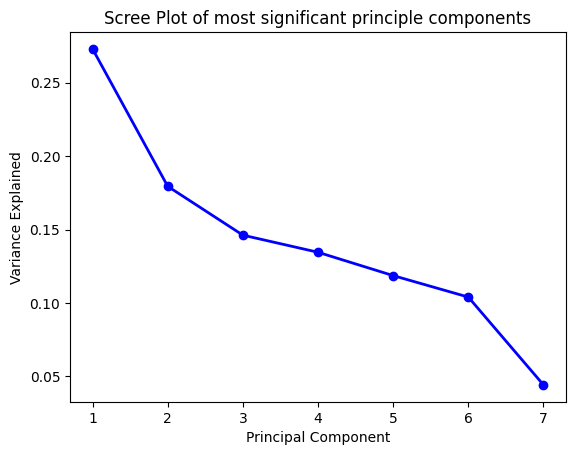

In [22]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot of most significant principle components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [16]:
# calculate min, max and limits
h = .02

x_min, x_max = train_result[:, 0].min() - 1, train_result[:, 0].max() + 1
y_min, y_max = train_result[:, 1].min() - 1, train_result[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# predict class using data and kNN classifier
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(train_result[:, 0], train_result[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()

ValueError: X has 2 features, but KNeighborsClassifier is expecting 7 features as input.

##### Data Standardisation (For PCA)

Cite week 8 lab sheet in report? Heavily used their code to help

### Making Scree plot for K-Means, Elbow Method

Plotting mean squared error E against number of clusters K

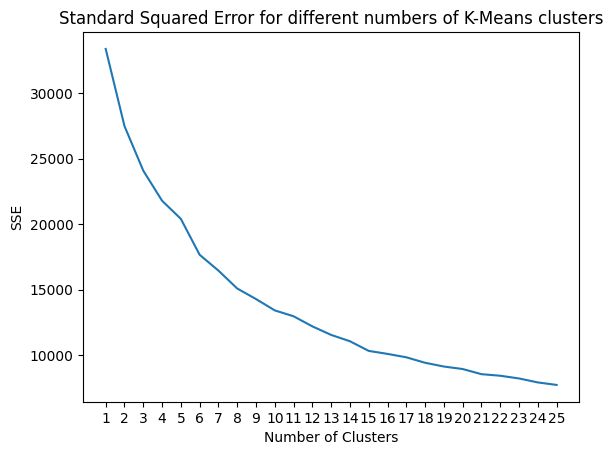

In [ ]:
upper = 26

elo_labels = temptation_data["elo_class"]
elo_features = temptation_data.drop(columns=["elo_class"])

# Standardize ELO features
scaler = StandardScaler()
scaled_elo_feats = scaler.fit_transform(elo_features)

# Find standard squared error for each k
SSE = []
for k in range(1, upper):
    pre_k_means = KMeans(n_clusters=k, n_init=3)
    pre_k_means.fit(scaled_elo_feats)
    # Record SSE for this k
    SSE.append(pre_k_means.inertia_)

# Create Scree plot
plt.title("Standard Squared Error for different numbers of K-Means clusters")
plt.plot(range(1, upper), SSE)
plt.xticks(range(1, upper))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Applying K-Means

c:\Users\s2202694\Downloads\python portable\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'PC2')

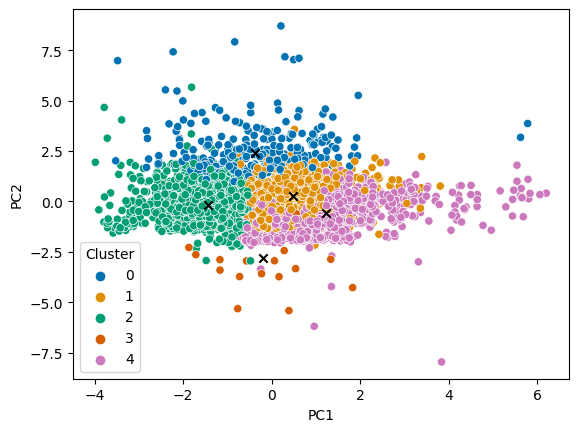

In [ ]:
# Instantiate K-Means model
num_clusters = 5
num_PCA_components = 7

# Apply PCA to reduce number of dimensions
pca = PCA(n_components=num_PCA_components).fit(scaled_elo_feats)
pca_scores = pca.transform(scaled_elo_feats)

# Apply K-Means clustering
model_kmeans = KMeans(n_clusters=num_clusters, max_iter=10) # Lila Justify why max_iter=5
pca_scores_kmeans = model_kmeans.fit(pca_scores)

# Find cluster centres
centres = np.array(model_kmeans.cluster_centers_)

# Initialise new dataframe for K-Means predictions
kmeans_df = pd.DataFrame(pca_scores)
predicted = []

# Fit model to each PCA score
for s in pca_scores:
    predicted.append(model_kmeans.predict(s.reshape(1, -1)))

# Helper method to convert 'predicts's list format into a single element
def list_to_elem(lst):
    '''Converts single element list to an element'''
    return lst[0]

# Add predicted points to dataframe
kmeans_df['Cluster'] = predicted
kmeans_df['Cluster'] = kmeans_df['Cluster'].apply(list_to_elem)

# Plot scatter plot
sns.color_palette("colorblind")

sns.scatterplot(x=kmeans_df.iloc[:,0],
                y=kmeans_df.iloc[:,1],
                hue=kmeans_df['Cluster'],
                palette='colorblind')

plt.scatter(centres[:,0], centres[:,1], marker="x", color='black')

# Lila check these should be labelled PC1 and PC2
plt.xlabel('PC1')
plt.ylabel('PC2')
